In [1]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USERNAME']
dj.config['database.password'] = os.environ['DJ_PASSWORD']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 10

name = 'vei2'
os.environ["DJ_SCHEMA_NAME"] = f"metrics_{name}"
dj.config["nnfabrik.schema_name"] = os.environ["DJ_SCHEMA_NAME"]

In [114]:
import os
import wandb
from tqdm import tqdm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["figure.figsize"] = (3, 3)
import seaborn as sns
import torch
from torch import load
from scipy.stats import beta, gamma, lognorm

from nnfabrik.main import *
from mei.main import MEISeed, MEIMethod
from nnfabrik.main import Dataset, my_nnfabrik
from nnsysident.tables.experiments import TrainedModel, schema
from nnsysident.tables.mei import MEISelector, TrainedEnsembleModel, MEI, MEIMonkey, MEIExperimentsMouse, Gradients, MENI
from nnvision.tables.main import Recording
from nnsysident.datasets.mouse_loaders import static_loaders

device = "cuda"
random_seed = 42

In [8]:
schema.jobs

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp


___

## MENI

In [3]:
loss, seed = TrainedModel().fetch("validation_loss", "seed")
dataloaders, model = (TrainedModel & "seed = {}".format(seed[np.argmin(loss)])).load_model()
model.eval();
model.to("cuda");

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ig

In [4]:
means, images = [], []
for image, response, _, _ in dataloaders["test"]['27940-2-13-0']:
    behavior = torch.zeros((image.shape[0], 3)).to(device)
    pupil_center = torch.zeros((image.shape[0], 2)).to(device)
    
    means.append(model.predict_mean(image, data_key='27940-2-13-0', behavior=behavior, pupil_center=pupil_center).cpu().data.numpy())
    images.append(image.cpu().data.numpy())
means = np.vstack(means)
images = np.vstack(images)

In [5]:
idx = np.argmax(means, axis=0)

In [7]:
selected_uids = MEISelector().fetch("unit_id")
for i, uid in tqdm(enumerate(dataloaders["test"]['27940-2-13-0'].dataset.neurons.unit_ids)):
    if uid in selected_uids:
        meni = images[idx[i]][None, ...]
        key = {'dataset_fn': 'nnsysident.datasets.mouse_loaders.static_loaders',
                 'dataset_hash': 'b57b0aafe499fe986cb5b4ba579c0cc9',
                 'unit_id': uid,
                 'data_key': '27940-2-13-0',
                 'meni': meni}
        MENI().insert1(key)

7619it [02:16, 55.87it/s] 


In [11]:
MEIMethod()#.fetch("method_config")[0]

method_fn name of the method function,method_hash hash of the method config,method_config method configuration object,method_ts UTZ timestamp at time of insertion,method_comment a short comment describing the method
mei.methods.gradient_ascent,58f0fdc9125c719579c51ca9eb8d9186,=BLOB=,2023-10-20 16:57:44,"VEI-, from MEI, orthogonal, val/test ensemble"
mei.methods.gradient_ascent,602cb598abf0e036a2a0067b4e210d89,=BLOB=,2023-10-20 16:57:35,"VEI+, from MEI, orthogonal, val/test ensemble"
mei.methods.gradient_ascent,b41f6b8a50c59494f5888a6f198b1314,=BLOB=,2023-10-19 19:04:47,MEI


In [13]:
entry = {'method_fn': 'mei.methods.gradient_ascent',
         'method_config': {'initial': {'path': 'mei.initial.OneValue', 
                                       'kwargs': {'fill_value': 0.001}},
                          'optimizer': {'path': 'torch.optim.SGD',
                                        'kwargs': {'lr': 0.05}},
                          'precondition': {'path': 'mei.legacy.ops.GaussianBlur',
                                           'kwargs': {'sigma': 1}},
                          'stopper': {'path': 'mei.stoppers.EarlyStopping', 
                                      'kwargs': {'patience': 20, 'min_iter': 200, 'max_iter': 3000}},
                          'objectives': [{'path': 'mei.objectives.EvaluationObjective',
                                          'kwargs': {'interval': 10}}],
                          'device': 'cuda',
                          'mei_class_name': 'VEI',
                          'ref_level': 1.0,
                          'variance_optimization': 'max',
                          'scale': 1000,
                          'dx': 0.02,
                          'orthogonal_vei': {'mei_type': 'MENI'},
                          'potential_well_function': 'linear', 
                          'validation_ensemble': 'df974e58ad062c788592bf95e77a2b03',
                          'test_ensemble': '62b9f62bc2c059dbae564d25bce4b4e4'},
         'comment': 'VEI+, from MENI, orthogonal, val/test ensemble'}
# MEIMethod().add_method(**entry)

In [38]:
table = (MEIMethod() & "method_hash = '454eb515b5737051ef0319ee40263ae8'")
method_config = table.fetch1("method_config")
method_config["optimizer"]["kwargs"]['lr'] = 0.001
table._update("method_config", method_config)

In [16]:
uids = MEI().fetch("unit_id")[:700]
mhashs = ["211d281c91522baa1981ed27d31c662d", "454eb515b5737051ef0319ee40263ae8"]

restrictions = []
for uid in uids:
    for mhash in mhashs:
        restrictions.append({
         'dataset_fn': 'nnsysident.datasets.mouse_loaders.static_loaders',
         'dataset_hash': 'b57b0aafe499fe986cb5b4ba579c0cc9',
         'ensemble_hash': '2c2e63c647c6c032c126dfe804d5bc06',
         'method_fn': 'mei.methods.gradient_ascent',
         'method_hash': mhash,
         'unit_id': uid,
         'data_key': '27940-2-13-0',
         })

In [17]:
entry = {'experiment_name': 'Orthogonal VEIs from MENIs',
 'experiment_fabrikant': 'kklurz',
 'experiment_comment': 'Create orthogonal VEIs from MENIs. Many neurons. Jiakun dataset.',
 "restrictions": restrictions,
}
MEIExperimentsMouse().add_entry(**entry)

___

In [6]:
experiment_names = ["Orthogonal VEIs from MENIs"]
for experiment_name in experiment_names:
    restr = MEIExperimentsMouse.Restrictions & f'experiment_name="{experiment_name}"'
    MEI.progress(restr)

MEI                  Completed 33 of 1400 (2.4%)   2023-10-26 20:23:20


___

## Orthogonal VEIs

In [5]:
# neuron_ids = [1065,  309,  542,   58, 1321, 1993, 1023,  429, 1552,  174, 1380,
#                 912, 1253, 1553, 1343, 1520,  647, 1508, 1411,  433,  303, 1846,
#                 150, 2216,  440, 1271,  273, 1310, 1155,  585, 1281, 1724,   83,
#                 975, 2103,  633, 1996,  229, 1741,  555, 2218,  546, 1082,  605,
#                1430,  953,  323, 2104, 1903, 1417, 1414,  470, 1410, 1408,  649,
#                2203, 1939, 2238, 1317, 2229,  296,  327, 1132,  277, 1457,  812,
#                 301,   62,  611,  365,  251, 1938,  571, 1081, 1190, 1375, 1925,
#                2249, 1658,  271, 1042, 1303,  352,  666, 1005, 1338,  981,  660,
#                 550, 2179, 2197, 1731,  973,  683,  638, 1496, 1512,  567,   39,
#                  73, 1515, 1399, 1554, 1269, 1488,  767,  595,  395, 1178,  685,
#                1210,  512, 1442, 1352,  589, 1332,  883, 1909,  306, 1077,  449,
#                 343,  601,  775, 1311, 1293,  739, 1142, 2190, 1115,  564, 2153,
#                 330,  313,  287,   47, 2184,  439, 1152,  832,  430,  333,  507,
#                2217, 1262,  155,  933,  383,  460, 2094, 1532,  359,  329, 1453,
#                2240, 1935,  659, 1517,   11, 2138,  362, 1268, 1927,  137,  578,
#                1975, 1402, 1987,  665, 1945, 1967,  586, 1904,  455, 2227, 1480,
#                1666, 1066, 1931,  636, 1819,  511, 1353, 2122, 2154,  749]

In [56]:
experiment_name = "Orthogonal VEIs from MENIs"
table = MEI() & (MEIExperimentsMouse.Restrictions() & f"experiment_name = '{experiment_name}'") #& "unit_id in {}".format(tuple(neuron_ids))

score, mean, variance, method_config, unit_id, mei = table.load_data(["score", "mean", "variance", "method_config", "unit_id", "mei"])
mei = [element for element in mei]
vei_type = np.array([dictionary["variance_optimization"] for dictionary in method_config])

100% 1400/1400 [00:00<00:00, 6044.00it/s]


In [77]:
data_vei = pd.DataFrame.from_dict({"score": score, "mean": mean, "variance": variance, "vei_type": vei_type, "unit_id": unit_id, "mei": mei})

# Get MEI data
mhash = np.unique(table.fetch("method_hash"))
key = (table & "method_hash = '{}'".format(mhash[0])).proj().fetch(as_dict=True)
for k in key:
    k["method_hash"] = 'b41f6b8a50c59494f5888a6f198b1314' # MEI
mei_score, mei_mean, mei_variance, mei_unit_id, mei_mei = (MEI() & key).load_data(["score", "mean", "variance", "unit_id", "mei"])
mei_mei = [element for element in mei_mei]
data_mei = pd.DataFrame.from_dict({"score": mei_score, "mean": mei_mean, "variance": mei_variance, "unit_id": mei_unit_id, "mei": mei_mei})
data_mei["vei_type"] = "MEI"

data = pd.concat([data_vei, data_mei])
data.sort_values(["unit_id"], ignore_index=True, inplace=True)

100% 700/700 [00:00<00:00, 5549.29it/s]


In [78]:
if 'orthogonal_vei' in method_config[0]:
    if method_config[0]["orthogonal_vei"]["mei_type"] == "MENI":
        dataloaders, model = (TrainedEnsembleModel & "ensemble_hash = '{}'".format(method_config[0]["test_ensemble"])).load_model()
        dataloader = dataloaders["train"]
        data_key = list(dataloader.keys())[0]
        all_uids = dataloader[data_key].dataset.neurons.unit_ids
        model.eval();
        model.to("cuda");
        data_meni = pd.DataFrame((MENI & table).fetch("unit_id", "meni", as_dict=True))

    means, variances = [], []
    for _, (uid, meni) in data_meni.iterrows():
        idx = np.where(all_uids == uid)[0].item()

        behavior = torch.zeros((1, 3)).to(device) if model.members[0].modulator else None
        pupil_center = torch.zeros((1, 2)).to(device) if model.members[0].shifter else None

        means.append(model.predict_mean(torch.from_numpy(meni).to(device), 
                                        behavior=behavior,
                                        pupil_center=pupil_center, 
                                        data_key=data_key).cpu().data.numpy()[0, idx])
        variances.append(model.predict_variance(torch.from_numpy(meni).to(device),
                                                behavior=behavior, 
                                                pupil_center=pupil_center, 
                                                data_key=data_key).cpu().data.numpy()[0, idx])
    data_meni["mean"] = means
    data_meni["variance"] = variances
    data_meni["vei_type"] = "CEI"
    data_meni.rename(columns={"meni": "mei"}, inplace=True)
    data_cei = data_meni
else:
    data_cei = data_mei
data = pd.concat([data, data_cei])
data.sort_values(["unit_id"], ignore_index=True, inplace=True)

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} wh

In [81]:
dat_mei = data.loc[data["vei_type"] == "MEI"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})
dat_cei = data.loc[data["vei_type"] == "CEI"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})
dat_min = data.loc[data["vei_type"] == "min"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})
dat_max = data.loc[data["vei_type"] == "max"].sort_values(["unit_id"], ignore_index=True).replace({"min": "VEI-", "max": "VEI+"})

/usr/local/lib/python3.9/dist-packages/pandas/core/array_algos/replace.py:86: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


In [82]:
dat_min["norm_mean - 1"] = dat_min["mean"]/dat_cei["mean"] - 1
dat_min["norm_var - 1"] = dat_min["variance"]/dat_cei["variance"] - 1

dat_max["norm_mean - 1"] = dat_max["mean"]/dat_cei["mean"] - 1
dat_max["norm_var - 1"] = dat_max["variance"]/dat_cei["variance"] - 1

dat_cei["abs_var_diff"] = dat_max["variance"] - dat_min["variance"]
dat_cei["norm_var_diff"] = dat_max["norm_var - 1"] - dat_min["norm_var - 1"]

In [86]:
min_mean_diff = 0.001
valid_unit_ids = (set(dat_min.loc[abs(dat_min["norm_mean - 1"]) <= min_mean_diff]["unit_id"]) & 
                  set(dat_max.loc[abs(dat_max["norm_mean - 1"]) <= min_mean_diff]["unit_id"]) &
                  set(dat_cei.loc[dat_cei["abs_var_diff"] > 0]["unit_id"]) 
                 )

dat_min = dat_min.loc[dat_min["unit_id"].isin(valid_unit_ids)]
dat_max = dat_max.loc[dat_max["unit_id"].isin(valid_unit_ids)]
dat_mei = dat_mei.loc[dat_mei["unit_id"].isin(valid_unit_ids)]
dat_cei = dat_cei.loc[dat_cei["unit_id"].isin(valid_unit_ids)]

neuron_ids = dat_cei.sort_values("norm_var_diff")["unit_id"].to_numpy()
neuron_ids_abs = dat_cei.sort_values("abs_var_diff")["unit_id"].to_numpy()

#### Check basics of results

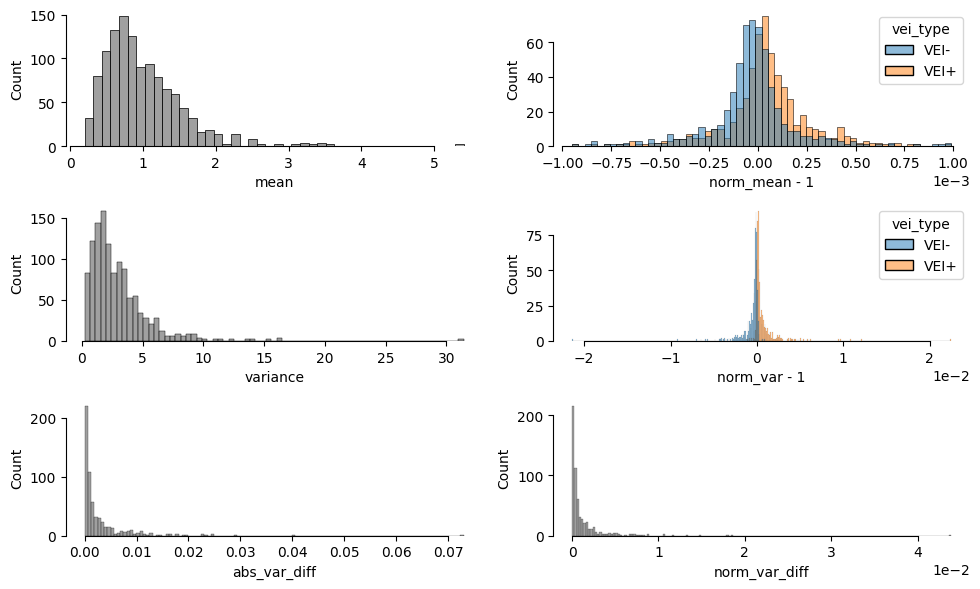

In [89]:
fig, axes = plt.subplots(3,2, figsize=(10, 6))
sns.histplot(data=pd.concat([dat_min, dat_max]), x="mean", ax=axes[0][0], color="gray")
sns.histplot(data=pd.concat([dat_min, dat_max]), x="norm_mean - 1", ax=axes[0][1], hue="vei_type")

sns.histplot(data=pd.concat([dat_min, dat_max]), x="variance", ax=axes[1][0], color="gray")
sns.histplot(data=pd.concat([dat_min, dat_max]), x="norm_var - 1", ax=axes[1][1], hue="vei_type")

sns.histplot(data=dat_cei, x="abs_var_diff", ax=axes[2][0], color="gray")
sns.histplot(data=dat_cei, x="norm_var_diff", ax=axes[2][1], color="gray")

# fig.delaxes(axes[2][1])
fig.tight_layout()
sns.despine(trim=True)
axes[0][1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
axes[1][1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
axes[2][1].ticklabel_format(axis="x", style='scientific', scilimits=(0,0))
# fig.savefig("orthogonal_veis_variance_analysis" + ".png", bbox_inches="tight", transparent=False)

#### Check angles

In [90]:
def angle(u, v):
    u = u.reshape(-1)
    v = v.reshape(-1)

    nominator = (u*v).sum()
    denominator = np.linalg.norm(u)*np.linalg.norm(v)
    return np.degrees(np.arccos(nominator/denominator))

In [91]:
angles_max, angles_min = [], []
for unit_id in valid_unit_ids:
    cei = dat_cei.loc[(dat_cei["unit_id"] == unit_id)]["mei"].item()
    vei_max = dat_max.loc[(dat_max["unit_id"] == unit_id)]["mei"].item()
    vei_min = dat_min.loc[(dat_min["unit_id"] == unit_id)]["mei"].item()
    angles_max.append(angle(cei, vei_max-cei).round(1))
    angles_min.append(angle(cei, vei_min-cei).round(1))

In [92]:
print((np.array(angles_max) == 90.0).all())
print((np.array(angles_min) == 90.0).all())

True
True


#### Plot VEI+ vs VEI- distributions of example neuron

In [94]:
uid = neuron_ids[-1] #neuron_ids_abs[-1] #neuron_ids[-1]
mei_table = MEIMethod & (table & "unit_id = {}".format(uid))
test_ensemble_hash = mei_table.fetch("method_config", limit=1)[0]["test_ensemble"]
dataloader, model = (TrainedModel & (TrainedEnsembleModel.Member & f"ensemble_hash = '{test_ensemble_hash}'" & "seed = 147")).load_model()
model.to(device)
model.eval();

idx = np.where(dataloader["train"]["27940-2-13-0"].dataset.neurons.unit_ids == uid)[0].item()

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} wh

In [95]:
vei_min = torch.from_numpy(data.loc[(data["unit_id"] == uid) & (data["vei_type"] == "min")]["mei"].item()).to(device)
vei_max = torch.from_numpy(data.loc[(data["unit_id"] == uid) & (data["vei_type"] == "max")]["mei"].item()).to(device)

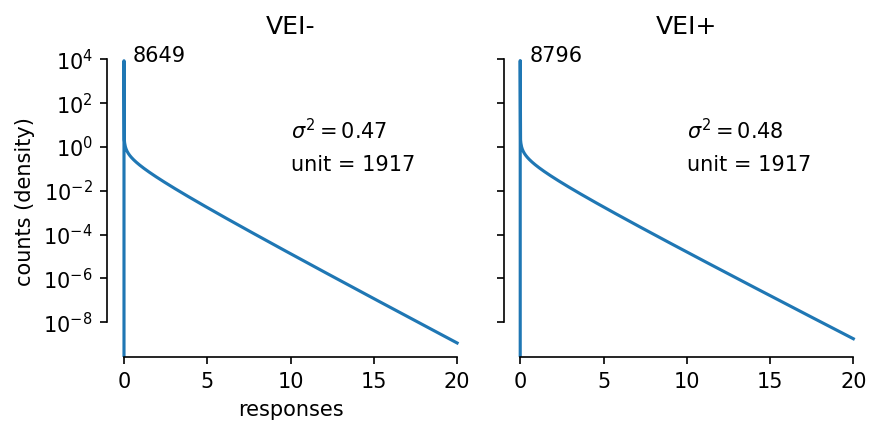

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharey=True, sharex=True)

for i, (ax, vei, label) in enumerate(zip(axes.flat, [vei_min, vei_max], ["VEI-", "VEI+"])):
    
    behavior = torch.zeros((vei_min.shape[0], 3)).to(device) 
    pupil_center = torch.zeros((vei_min.shape[0], 2)).to(device)
    theta, k, loc, q = model(vei, data_key="27940-2-13-0", behavior=behavior, pupil_center=pupil_center)
    var = np.round(model.predict_variance(vei, 
                                          data_key="27940-2-13-0",
                                          behavior=behavior,
                                          pupil_center=pupil_center)[0, idx].item(), decimals=2)
    
    theta = theta[0, idx].item()
    k = k[0, idx].item()
    loc = loc[0, idx].item()
    q = q[0, idx].item()
    
    x = np.linspace(0, 20, 1000)
    y_gamma = gamma(k, loc=loc, scale=theta).pdf(x[x>=loc]) * q
    y_uniform = np.ones(len(x[x<loc])) * (1-q)/loc
    y = np.hstack([y_uniform, y_gamma])
    
    # ax.fill_between(x[x<loc], y_uniform, lw=.1, color='firebrick', alpha=.6, zorder=1, label='uniform');
    # ax.fill_between(x[x>=loc], y_gamma, lw=.1, color='darkorange', alpha=.6, zorder=1, label='gamma');
    
    ax.plot(np.concatenate([np.array([0]), x]), np.concatenate([np.array([0]), y_uniform, y_gamma]))

    if i==0:
        ax.set(xlabel='responses', ylabel='counts (density)')
        
    # ax.set(xlim = (-2, 30))
    ax.set_title(label)
    ax.text(.5, .7, r"$\sigma^2 = {}$".format(var), transform=ax.transAxes)
    ax.text(.5, .6, r"unit = {}".format(uid), transform=ax.transAxes)
    
    ax.set_yscale("log")
    # ax.set(ylim=[0, 4])
    ax.text(.07, .95, "{}".format(int(y_uniform[0])), transform=ax.transAxes)

sns.despine(trim=True)
fig.tight_layout()

# fig.savefig('figures/' + name + ".png", bbox_inches='tight')

#### How many repeats are needed to distinguish the two?

In [97]:
def zig_pdf(theta, k, loc, q, samples):
    y_gamma = gamma(k, loc=loc, scale=theta).pdf(samples[samples>loc]) * q
    y_uniform = np.ones(len(samples[samples<=loc])) * (1-q)/loc
    log_y = np.hstack([y_uniform, y_gamma])
    return log_y

def get_params(vei, model, idx):
    behavior = torch.zeros((vei.shape[0], 3)).to(device) 
    pupil_center = torch.zeros((vei.shape[0], 2)).to(device)
    theta, k, loc, q = model(vei, data_key="27940-2-13-0", behavior=behavior, pupil_center=pupil_center)
    var = np.round(model.predict_variance(vei, 
                                          data_key="27940-2-13-0",
                                          behavior=behavior,
                                          pupil_center=pupil_center)[0, idx].item(), decimals=2)

    theta = theta[0, idx].item()
    k = k[0, idx].item()
    loc = loc[0, idx].item()
    q = q[0, idx].item()
    return theta, k, loc, q

In [98]:
def get_sigma_plus(all_samples_n, seed):
    np.random.seed(seed)

    # Get zig params from max vei
    theta, k, loc, q = get_params(vei_max, model, idx)

    # Sample from this distribution
    samples = gamma(k, loc=loc, scale=theta).rvs(all_samples_n[-1])
    uniform_samples = np.random.rand(all_samples_n[-1]) * loc
    uniform_samples_idx = (np.random.rand(all_samples_n[-1]) >= q)
    samples[uniform_samples_idx] = uniform_samples[uniform_samples_idx]

    all_p_sigma_plus = []
    for samples_n in all_samples_n:

        # Compute probability of the samples...
        # ... for max vei distribution
        theta, k, loc, q = get_params(vei_max, model, idx)
        p_plus = zig_pdf(theta, k, loc, q, samples[:samples_n])
        # ... for min vei distribution
        theta, k, loc, q = get_params(vei_min, model, idx)
        p_minus = zig_pdf(theta, k, loc, q, samples[:samples_n])

        # Compute probability of the samples coming from max vei distribution
        # p_sigma_plus = np.prod(p_plus)/(np.prod(p_plus) + np.prod(p_minus))
        p_sigma_plus = np.log(p_plus).sum() - np.logaddexp(np.log(p_plus).sum(), np.log(p_minus).sum())
        all_p_sigma_plus.append(p_sigma_plus)
    return all_p_sigma_plus

In [99]:
all_samples_n = np.arange(1, 101)

dat = pd.DataFrame(columns=["seed", "sigma", "samples_n"])
for seed in np.arange(20):
    all_p_sigma_plus = get_sigma_plus(all_samples_n, seed)
    
    dat_ = pd.DataFrame(columns=["seed", "sigma", "samples_n"])
    dat_["sigma"] = all_p_sigma_plus
    dat_["seed"] = seed
    dat_["samples_n"] = all_samples_n
    
    dat = pd.concat([dat, dat_])
dat["sigma"] = np.exp(dat["sigma"])

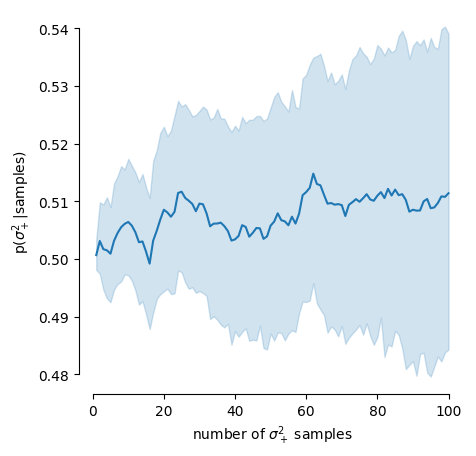

In [100]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ax.plot(all_samples_n, all_p_sigma_plus)
sns.lineplot(data=dat, x="samples_n", y="sigma", ax=ax)
ax.set(xlabel="number of $\sigma^2_+$ samples", ylabel=r"p($\sigma^2_+$|samples)")
sns.despine(trim=True)
# fig.savefig("orthogonal_veis_howmanyrepeats" + ".png", bbox_inches="tight", transparent=False)

___

#### Plot VEIs

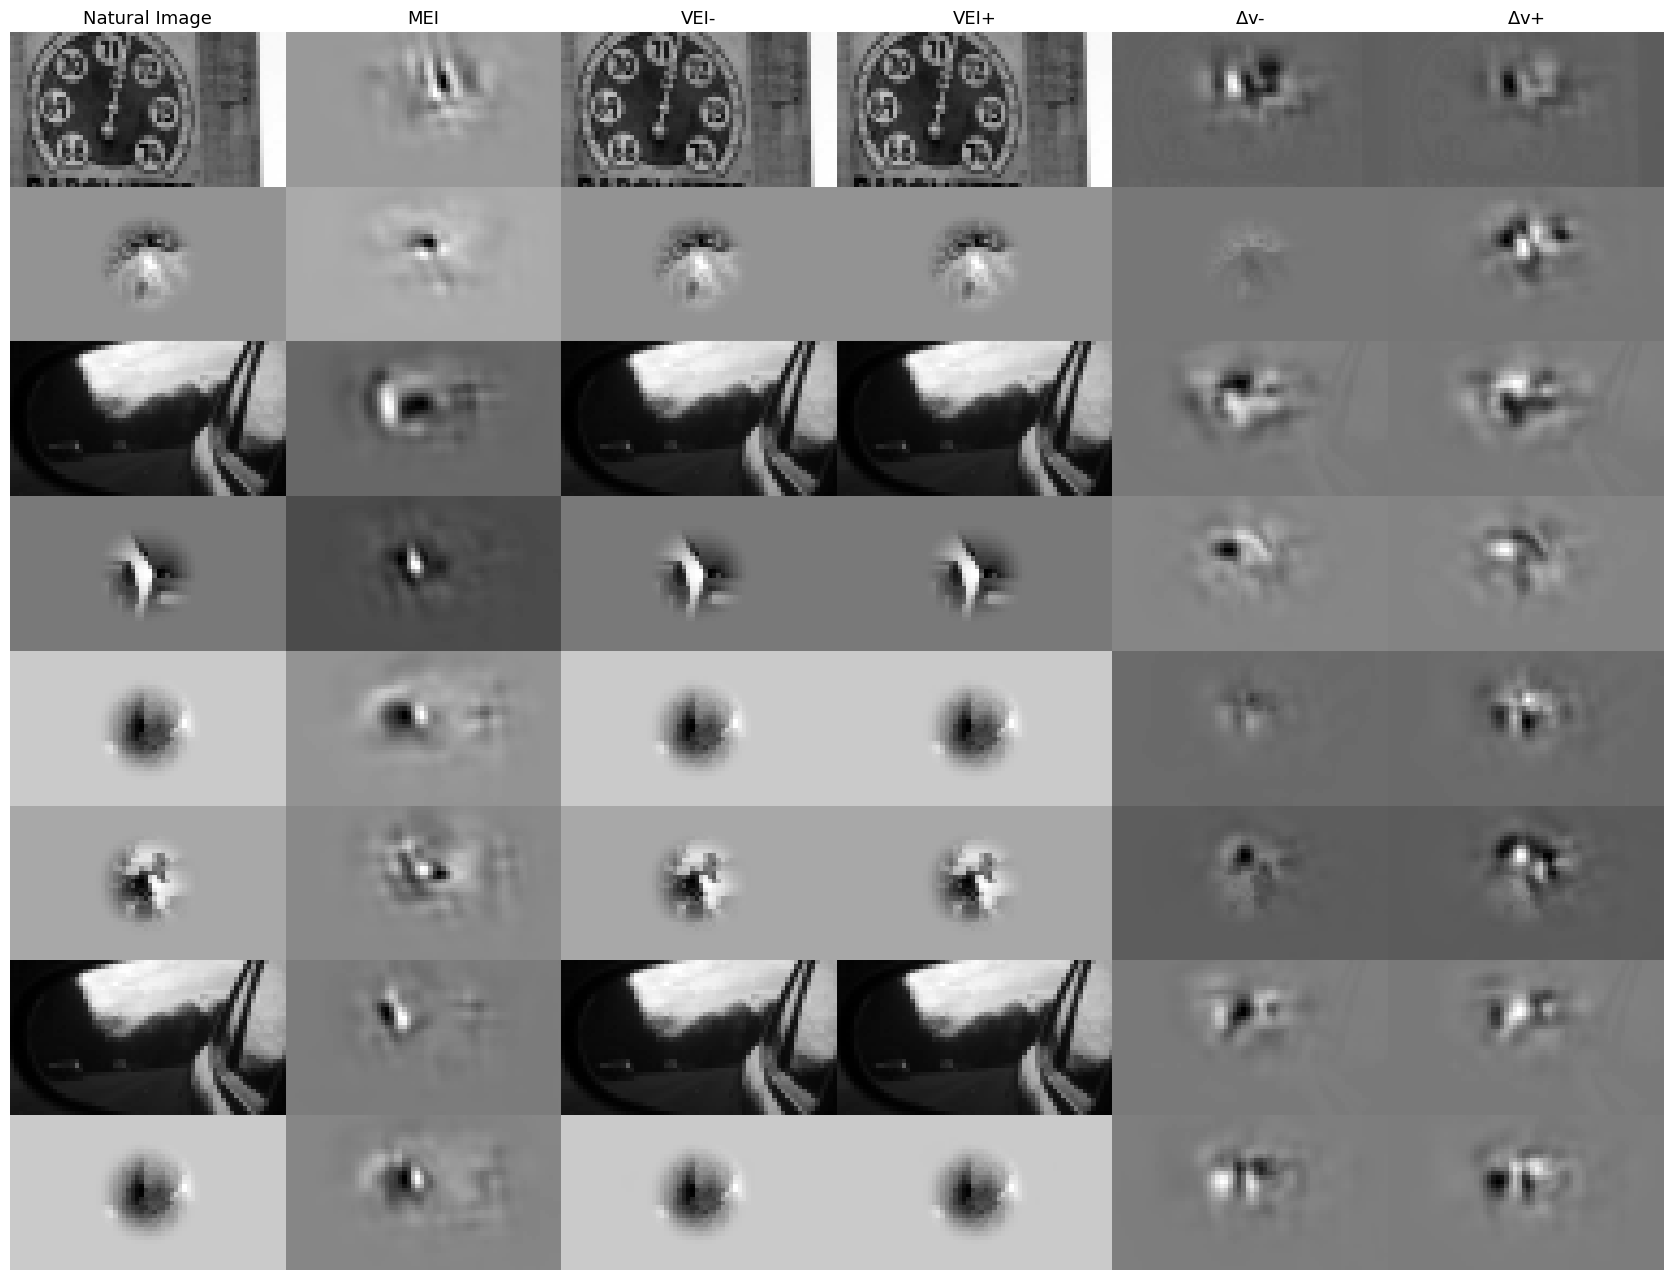

In [104]:
unit_ids = neuron_ids[-8:]
ratio = 64/36

fig, axes = plt.subplots(len(unit_ids), 6, figsize=(2*ratio*6, 2*len(unit_ids)+.3), dpi=100)
fontsize = 13

for i in range(len(unit_ids)):
    dat = data.loc[data["unit_id"] == unit_ids[i]]
    
    # CEI/VEI
    mei = dat.loc[dat["vei_type"] == "MEI"]["mei"].item().squeeze()
    cei = dat.loc[dat["vei_type"] == "CEI"]["mei"].item().squeeze()
    vei_min = dat.loc[dat["vei_type"] == "min"]["mei"].item().squeeze()
    vei_max = dat.loc[dat["vei_type"] == "max"]["mei"].item().squeeze()
    vmax = np.concatenate([cei, vei_min, vei_max]).max()
    vmin = np.concatenate([cei, vei_min, vei_max]).min()
    
    axes[i, 0].imshow(cei, cmap="gray", vmin=vmin, vmax=vmax) 
    axes[i, 1].imshow(mei, cmap="gray") 
    axes[i, 2].imshow(vei_min, cmap="gray", vmin=vmin, vmax=vmax) 
    axes[i, 3].imshow(vei_max, cmap="gray", vmin=vmin, vmax=vmax)

    # Delta
    delta_min = dat.loc[dat["vei_type"] == "min"]["mei"].item().squeeze() - cei
    delta_max = dat.loc[dat["vei_type"] == "max"]["mei"].item().squeeze() - cei
    vmax = np.concatenate([delta_min, delta_max]).max()
    vmin = np.concatenate([delta_min, delta_max]).min()
    
    axes[i, 4].imshow(delta_min, cmap="gray", vmin=vmin, vmax=vmax)    
    axes[i, 5].imshow(delta_max, cmap="gray", vmin=vmin, vmax=vmax)
    
    for j in range(6):
        axes[i, j].axis("off")

    if i == 0:
        axes[i, 0].set_title("Natural Image", fontsize=fontsize)
        axes[i, 1].set_title("MEI", fontsize=fontsize)
        axes[i, 2].set_title("VEI-", fontsize=fontsize)
        axes[i, 3].set_title("VEI+", fontsize=fontsize)
        axes[i, 4].set_title(r"$\Delta$v-", fontsize=fontsize)
        axes[i, 5].set_title(r"$\Delta$v+", fontsize=fontsize)
        
fig.subplots_adjust(wspace=0, hspace=-.1)
# fig.savefig("orthogonal_veis" + ".png", bbox_inches="tight", transparent=False)

In [109]:
tab = (TrainedEnsembleModel & "ensemble_hash = '62b9f62bc2c059dbae564d25bce4b4e4'")
_, model =  tab.load_model()
model.eval();
model.to("cuda");

/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:125: UserWarning: The default of `independent_bn_bias=True` will ignore the kwargs `bias`, `batch_norm_scale`, and `final_batchnorm_scale` when initializing the batchnorm. If you want to use these arguments, please set `independent_bn_bias=False`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/cores/conv2d.py:161: UserWarning: The averaged value of regularizer will be used.
  warnings.warn("The averaged value of regularizer will be used.", UserWarning)
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:63: UserWarning: Ignoring input {'mod_type': 'MLP'} when creating MLPModulator
  warnings.warn("Ignoring input {} when creating {}".format(repr(kwargs), self.__class__.__name__))
/usr/local/lib/python3.9/dist-packages/neuralpredictors/layers/modulators/mlp.py:14: UserWarning: Ignoring input {} when creating MLP
  warnings.warn("Ignoring input {} wh

In [110]:
dataset_config = (Dataset & tab).fetch1("dataset_config")
dataset_config["tier"] = "test"
dataset_config["return_test_sampler"] = True

In [115]:
dataloaders = static_loaders(**dataset_config)

Returning only test sampler with repeats...


In [138]:
data_key = '27940-2-13-0'

pred_means, pred_variances, real_means, real_variances = [], [], [], []
for image, response, pupil_center, behavior in dataloaders["test"][data_key]:
    mean = model.predict_mean(image, data_key=data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    variance = model.predict_variance(image, data_key=data_key, behavior=behavior, pupil_center=pupil_center).cpu().data.numpy()
    pred_means.append(mean.mean(0))
    pred_variances.append((variance + mean).mean(0) - mean.mean(0))
   
    real_means.append(torch.mean(response, axis=0).cpu().data.numpy())
    real_variances.append(torch.var(response, axis=0).cpu().data.numpy())

pred_means = np.vstack(pred_means)
pred_variances = np.vstack(pred_variances)
real_means = np.vstack(real_means)
real_variances = np.vstack(real_variances)

In [140]:
mean_threshold = 1.e-3
var_threshold = 0.0001

result, signs, model_signs, real_signs = [], [], [], []
for i in range(real_means.shape[1]):
    

    idx = np.argsort(real_means[:, i])
    diffs = np.diff(real_means[:, i][idx])
    new_idx = np.where(diffs < mean_threshold)[0]

    target_means = real_means[:, i][idx][new_idx] - real_means[:, i][idx][new_idx+1]
    target_variances = real_variances[:, i][idx][new_idx] - real_variances[:, i][idx][new_idx+1]

    model_means = pred_means[:, i][idx][new_idx] - pred_means[:, i][idx][new_idx+1]
    model_variances = pred_variances[:, i][idx][new_idx] - pred_variances[:, i][idx][new_idx+1]
    
    model_sign = np.sign(model_variances[abs(target_variances) > var_threshold]).astype(int)
    real_sign = np.sign(target_variances[abs(target_variances) > var_threshold]).astype(int)
    sign = real_sign == model_sign
    if len(sign)>0:
        result.append(sum(sign)/len(sign))
        signs.append(sign)
        model_signs.append(model_sign)
        real_signs.append(real_sign)
        
signs = np.hstack(signs)
model_signs = np.hstack(model_signs)
real_signs = np.hstack(real_signs)

In [141]:
model_signs.shape

(141779,)

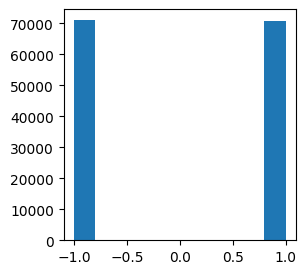

In [142]:
plt.hist(model_signs);

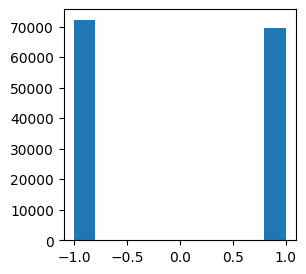

In [143]:
plt.hist(real_signs);

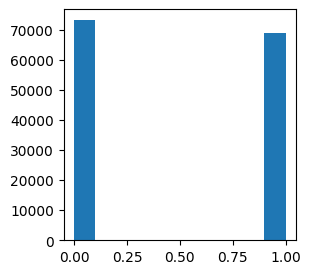

In [144]:
plt.hist(signs.astype(int));